In [51]:
import pandas as pd
import datetime
import nltk

import re

#For model
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Export as csv
import pyarrow as pa
import pyarrow.csv as csv

In [52]:
#Load in data and convert to dictionary
#https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter
df = pd.read_csv("twcs.csv")
df = df.dropna(subset = "text") #Remove NA text if any

cs = df.to_dict(orient = "records")

In [53]:
df.len() #2811773 tweets

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"@823869 Hey, we'd be happy to look into this f...",NaN,2987948.0
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty s...,2987947,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,@143549 @sprintcare You have to go to https://...,NaN,2812239.0
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,"@823870 Sounds delicious, Sarah! 😋 https://t.c...",NaN,2987950.0
2811773,2987950,823870,True,Tue Nov 21 22:01:04 +0000 2017,@AldiUK warm sloe gin mince pies with ice cre...,"2987951,2987949",NaN


In [54]:
#Analyse all tweets
#Create negativity score and create a new column to contain the results
vader = SentimentIntensityAnalyzer()

for text in cs:
    text["negative"] = vader.polarity_scores(text["text"])["neg"]

In [55]:
#Convert dictionary to df
cs2 = pd.DataFrame(cs)

In [65]:
#Save as csv so I don't have to do 20 mins of processing
#new_pa_dataframe = pa.Table.from_pandas(cs2)

#write csv
#csv.write_csv(new_pa_dataframe, "output.csv")

In [73]:
#Load data previously saved
df = pd.read_csv("output.csv")

In [69]:
#Remove company tweets from the dataframe
df["author_id"] = pd.to_numeric(df["author_id"], errors = "coerce")
cs3 = df.dropna(subset = ["author_id"])

In [78]:
#Negativity score bracketing information
print(len(cs3))
print((cs3["negative"] > 0).value_counts()) #657819 negative
print(657819/1537843)
print((cs3["negative"] > 0.3).value_counts()) #77537 negative
print(77537/1537843)
print((cs3["negative"] > 0.5).value_counts()) #10195 negative
print(10195/1537843)

1537843
False    880024
True     657819
Name: negative, dtype: int64
0.4277543286278248
False    1460306
True       77537
Name: negative, dtype: int64
0.05041932108804345
False    1527648
True       10195
Name: negative, dtype: int64
0.006629415356444058


In [71]:
#Turn column into True/False rather than numeric
cs3["in_response_to_tweet_id"] = pd.isna(cs3["in_response_to_tweet_id"])

C:\Users\Sashh\AppData\Local\Temp\ipykernel_8816\3503456704.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs3["in_response_to_tweet_id"] = pd.isna(cs3["in_response_to_tweet_id"])


In [109]:
#Display 100 tweets to read for validation purposes
pd.set_option("display.max_colwidth", None)
print(cs3.sort_values("negative", ascending = False)["text"].head(100)) #Change between True/False for 100 non-negative/negative

1834711                                                                                                                                                                                                                                                                                                          WTF
216483                                                                                                                                                                                                                                                                                                     SCREAMING
1934212                                                                                                                                                                                                                                                                                                       fiery.
741778         @AppleSupport NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO

0.07554541458392941
0.06423138666776747 0.08632992864636137


Text(0, 0.5, 'Mean')

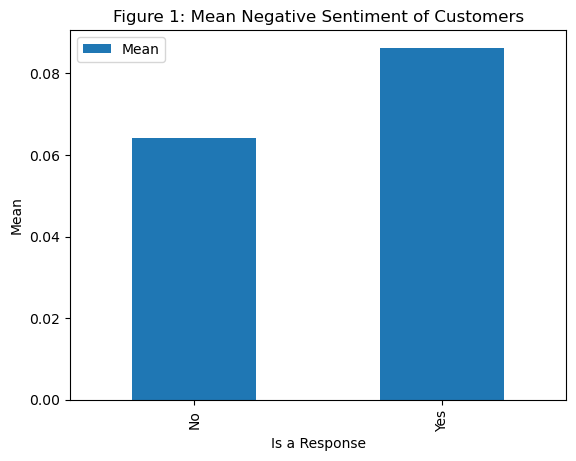

In [90]:
print(cs3["negative"].mean()) #Mean for all
#Binary based on above or equal to/below mean
cs3["nbinary"] = (cs3["negative"] >= (cs3["negative"].mean())).astype(int)

#Mean for each response
noresp = cs3.loc[~cs3["in_response_to_tweet_id"], "negative"].mean() #Is a response
resp = cs3.loc[cs3["in_response_to_tweet_id"], "negative"].mean() #Is not a response

print(noresp, resp)

#dataframe to create plot
data = {
    "Response": ["No", "Yes"],
    "Mean": [noresp, resp]
}
data = pd.DataFrame(data)
#Mean from text to numeric
data["Mean"] = pd.to_numeric(data["Mean"])

#Plot
plt = data.plot.bar(x = "Response", y = "Mean")
plt.set_title("Figure 1: Mean Negative Sentiment of Customers")
plt.set_xlabel("Is a Response")
plt.set_ylabel("Mean")

In [ ]:
#Save as csv for R
new_pa_dataframe = pa.Table.from_pandas(cs3)

#write csv
csv.write_csv(new_pa_dataframe, "output2.csv")

In [ ]:
#These are the lines of code used in R to produce the logistic regression and check AIC

#wrkdir <- setwd("C:/Users/Sashh/Documents/ExternalBackup/Exeter/Programs/python/961Assessment2")
#wrkdir

#cs3 <- read.csv("output2.csv")

#Logistic regression
#m <- glm(nbinary ~ in_response_to_tweet_id, data = cs3, family = "binomial")
#summary(m) #0.489 increase in the log odds

#m0 <- glm(nbinary ~ NULL, data = cs3, family = "binomial")
#summary(m0)